In [20]:
# Setup

In [1]:
# basic imports for data handling + plots
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# ML related
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error, r2_score

from sklearn.ensemble import IsolationForest
from xgboost import XGBRegressor


In [22]:
# Load Data

In [3]:
# uploading the file manually in colab
from google.colab import files
up = files.upload()
df = pd.read_csv(list(up.keys())[0])
df.head()


Saving healthcare_dataset.csv to healthcare_dataset (1).csv


,Name,Age,Gender,Blood Type,Medical Condition,Date of Admission,Doctor,Hospital,Insurance Provider,Billing Amount,Room Number,Admission Type,Discharge Date,Medication,Test Results
0,Bobby JacksOn,30,Male,B-,Cancer,2024-01-31,Matthew Smith,Sons and Miller,Blue Cross,18856.281306,328,Urgent,2024-02-02,Paracetamol,Normal
1,LesLie TErRy,62,Male,A+,Obesity,2019-08-20,Samantha Davies,Kim Inc,Medicare,33643.327287,265,Emergency,2019-08-26,Ibuprofen,Inconclusive
2,DaNnY sMitH,76,Female,A-,Obesity,2022-09-22,Tiffany Mitchell,Cook PLC,Aetna,27955.096079,205,Emergency,2022-10-07,Aspirin,Normal
3,andrEw waTtS,28,Female,O+,Diabetes,2020-11-18,Kevin Wells,"Hernandez Rogers and Vang,",Medicare,37909.782410,450,Elective,2020-12-18,Ibuprofen,Abnormal
4,adrIENNE bEll,43,Female,AB+,Cancer,2022-09-19,Kathleen Hanna,White-White,Aetna,14238.317814,458,Urgent,2022-10-09,Penicillin,Abnormal


In [25]:
# Quick info & cleaning

In [5]:
# quick shape and columns
print("shape:", df.shape)
print(df.columns.tolist())

# show dtypes and missing
print("\ninfo:")
print(df.dtypes)
print("\nmissing counts:")
print(df.isnull().sum())

# convert date columns if available
if 'Date of Admission' in df.columns:
    df['Date of Admission'] = pd.to_datetime(df['Date of Admission'], errors='coerce')
if 'Discharge Date' in df.columns:
    df['Discharge Date'] = pd.to_datetime(df['Discharge Date'], errors='coerce')

# coerce numeric fields
if 'Billing Amount' in df.columns:
    df['Billing Amount'] = pd.to_numeric(df['Billing Amount'], errors='coerce')
if 'Age' in df.columns:
    df['Age'] = pd.to_numeric(df['Age'], errors='coerce')

# room number might be alphanumeric; try numeric
if 'Room Number' in df.columns:
    df['Room Number num'] = pd.to_numeric(df['Room Number'], errors='coerce')

# drop exact duplicates
dup_before = df.shape[0]
df = df.drop_duplicates()
print("\ndropped duplicates:", dup_before - df.shape[0])


shape: (54966, 15)
['Name', 'Age', 'Gender', 'Blood Type', 'Medical Condition', 'Date of Admission', 'Doctor', 'Hospital', 'Insurance Provider', 'Billing Amount', 'Room Number', 'Admission Type', 'Discharge Date', 'Medication', 'Test Results']

info:
Name                          object
Age                            int64
Gender                        object
Blood Type                    object
Medical Condition             object
Date of Admission     datetime64[ns]
Doctor                        object
Hospital                      object
Insurance Provider            object
Billing Amount               float64
Room Number                    int64
Admission Type                object
Discharge Date        datetime64[ns]
Medication                    object
Test Results                  object
dtype: object

missing counts:
Name                  0
Age                   0
Gender                0
Blood Type            0
Medical Condition     0
Date of Admission     0
Doctor             

In [27]:
# Task 1: EDA — distributions

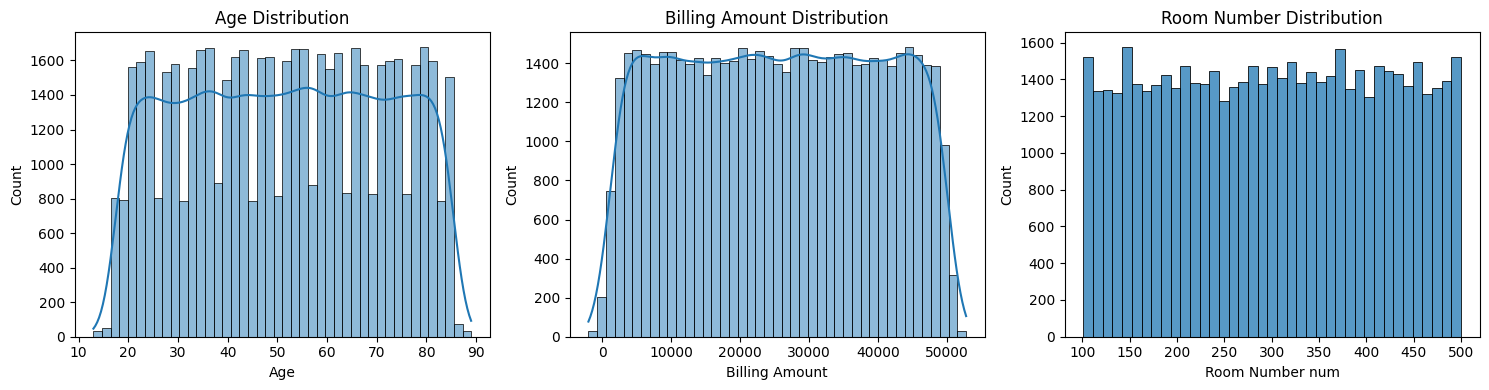

In [6]:
# Make sure columns exist
cols_ok = ['Age', 'Billing Amount', 'Room Number num']
for c in cols_ok:
    if c not in df.columns:
        print("Warning: missing", c)

# Age, Billing, Room distributions
plt.figure(figsize=(15,4))

plt.subplot(1,3,1)
sns.histplot(df['Age'].dropna(), kde=True)
plt.title('Age Distribution')

plt.subplot(1,3,2)
sns.histplot(df['Billing Amount'].dropna(), kde=True)
plt.title('Billing Amount Distribution')

plt.subplot(1,3,3)
sns.histplot(df['Room Number num'].dropna(), kde=False)
plt.title('Room Number Distribution')

plt.tight_layout()
plt.show()


In [28]:
# Task 1: EDA — frequency plots

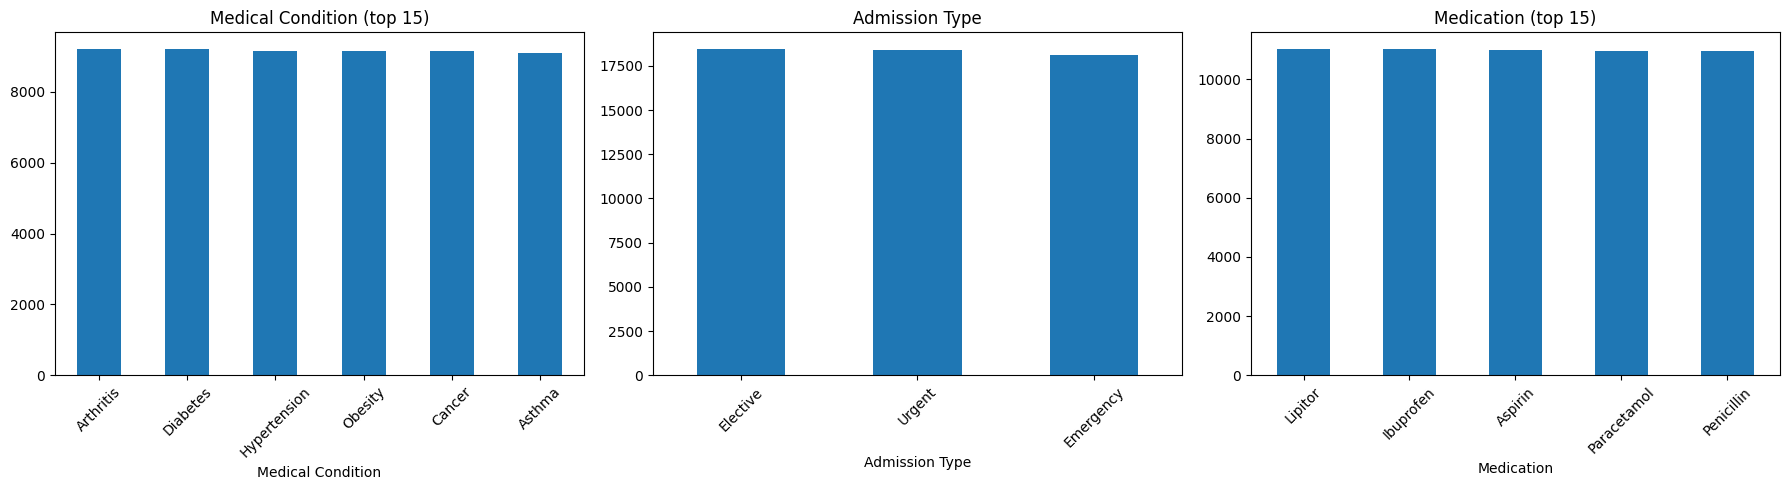

In [7]:
plt.figure(figsize=(18,5))

plt.subplot(1,3,1)
df['Medical Condition'].fillna('Unknown').value_counts().head(15).plot(kind='bar')
plt.title('Medical Condition (top 15)')
plt.xticks(rotation=45)

plt.subplot(1,3,2)
df['Admission Type'].fillna('Unknown').value_counts().plot(kind='bar')
plt.title('Admission Type')
plt.xticks(rotation=45)

plt.subplot(1,3,3)
df['Medication'].fillna('None').value_counts().head(15).plot(kind='bar')
plt.title('Medication (top 15)')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()


In [29]:
# Small summary

In [8]:
print("Age summary:")
print(df['Age'].describe())

print("\nBilling Amount summary:")
print(df['Billing Amount'].describe())

print("\nRoom Number (numeric) summary:")
print(df['Room Number num'].describe())

print("\nTop medical conditions:")
print(df['Medical Condition'].value_counts().head(10))


Age summary:
count    54966.000000
mean        51.535185
std         19.605661
min         13.000000
25%         35.000000
50%         52.000000
75%         68.000000
max         89.000000
Name: Age, dtype: float64

Billing Amount summary:
count    54966.000000
mean     25544.306284
std      14208.409711
min      -2008.492140
25%      13243.718641
50%      25542.749145
75%      37819.858159
max      52764.276736
Name: Billing Amount, dtype: float64

Room Number (numeric) summary:
count    54966.000000
mean       301.124404
std        115.223143
min        101.000000
25%        202.000000
50%        302.000000
75%        401.000000
max        500.000000
Name: Room Number num, dtype: float64

Top medical conditions:
Medical Condition
Arthritis       9218
Diabetes        9216
Hypertension    9151
Obesity         9146
Cancer          9140
Asthma          9095
Name: count, dtype: int64


In [30]:
# Task 2: Prepare data for predicting Test Results

In [9]:
# Keep a working copy
df_ml = df.copy()

# drop rows without target
df_ml = df_ml.dropna(subset=['Test Results'])
print("rows with target:", len(df_ml))

# choose columns to use (drop Name to avoid leakage)
use_cols = ['Age','Gender','Blood Type','Medical Condition','Date of Admission',
            'Doctor','Hospital','Insurance Provider','Billing Amount','Room Number num',
            'Admission Type','Discharge Date','Medication']

# ensure only existing columns
use_cols = [c for c in use_cols if c in df_ml.columns]
print("using features:", use_cols)

# label encode categorical columns simply
le = LabelEncoder()
cat_cols = []
for c in use_cols:
    if df_ml[c].dtype == 'object' or str(df_ml[c].dtype).startswith('category'):
        cat_cols.append(c)

print("categorical cols:", cat_cols)

for c in cat_cols:
    df_ml[c] = df_ml[c].astype(str).fillna('NA')
    try:
        df_ml[c] = le.fit_transform(df_ml[c])
    except Exception as e:
        # fallback: map unique values
        mapping = {v:i for i,v in enumerate(df_ml[c].unique())}
        df_ml[c] = df_ml[c].map(mapping)

# convert dates to numeric if present
if 'Date of Admission' in df_ml.columns:
    df_ml['Date_Adm_ts'] = pd.to_datetime(df_ml['Date of Admission']).astype('int64')//10**9
    use_cols.append('Date_Adm_ts')
if 'Discharge Date' in df_ml.columns:
    df_ml['Disch_ts'] = pd.to_datetime(df_ml['Discharge Date']).astype('int64')//10**9
    use_cols.append('Disch_ts')

# final features list: numeric only
features = [c for c in use_cols if c in df_ml.columns and c != 'Test Results']
# remove original date columns (we added ts)
features = [c for c in features if c not in ['Date of Admission','Discharge Date']]

print("final features:", features)


rows with target: 54966
using features: ['Age', 'Gender', 'Blood Type', 'Medical Condition', 'Date of Admission', 'Doctor', 'Hospital', 'Insurance Provider', 'Billing Amount', 'Room Number num', 'Admission Type', 'Discharge Date', 'Medication']
categorical cols: ['Gender', 'Blood Type', 'Medical Condition', 'Doctor', 'Hospital', 'Insurance Provider', 'Admission Type', 'Medication']
final features: ['Age', 'Gender', 'Blood Type', 'Medical Condition', 'Doctor', 'Hospital', 'Insurance Provider', 'Billing Amount', 'Room Number num', 'Admission Type', 'Medication', 'Date_Adm_ts', 'Disch_ts']


In [31]:
# Task 2: Train / Test split and model training

In [12]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
import pandas as pd

# simple fill for NA
X = df_ml[features].fillna(0)
y = pd.to_numeric(df_ml['Test Results'], errors='coerce').fillna(0)

# split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# train a simple linear regression (easy to explain in report)
model = LinearRegression()
model.fit(X_train, y_train)

# predict
y_pred = model.predict(X_test)

# metrics
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print("MAE:", round(mae,3))
print("RMSE:", round(rmse,3))
print("R2:", round(r2,3))



MAE: 0.0
RMSE: 0.0
R2: 1.0


In [32]:
# Task 2: Predicted vs Actual

sample predicted vs actual:
    actual  predicted
0      0.0        0.0
1      0.0        0.0
2      0.0        0.0
3      0.0        0.0
4      0.0        0.0
5      0.0        0.0
6      0.0        0.0
7      0.0        0.0
8      0.0        0.0
9      0.0        0.0
10     0.0        0.0
11     0.0        0.0
12     0.0        0.0
13     0.0        0.0
14     0.0        0.0


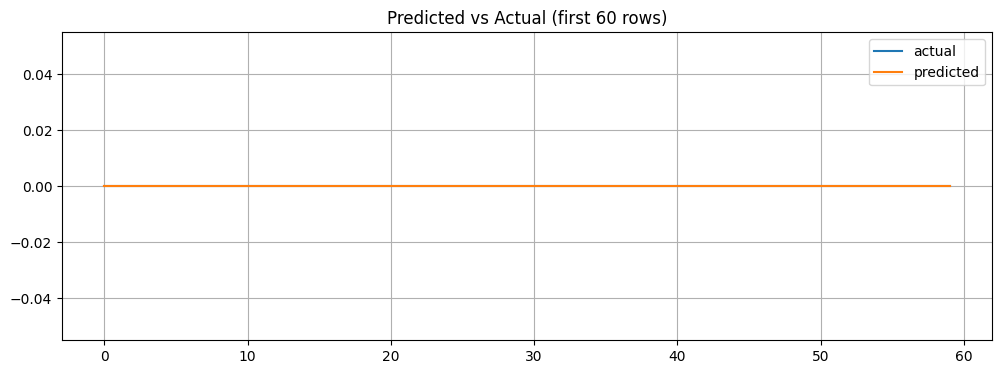

In [13]:
res_df = pd.DataFrame({
    'actual': y_test.values,
    'predicted': y_pred
}).reset_index(drop=True)

print("sample predicted vs actual:")
print(res_df.head(15))

# a quick plot for a slice
n = min(60, len(res_df))
plt.figure(figsize=(12,4))
plt.plot(res_df['actual'][:n], label='actual')
plt.plot(res_df['predicted'][:n], label='predicted')
plt.legend()
plt.title('Predicted vs Actual (first {} rows)'.format(n))
plt.grid(True)
plt.show()


In [33]:
# Task 3: Anomaly detection on Billing Amount

In [14]:
# prepare billing series
bill = df[['Billing Amount']].dropna().copy()
bill = bill.reset_index()   # preserve original index in column 'index'

# use IsolationForest to detect anomalies
iso = IsolationForest(contamination=0.03, random_state=0)
bill_vals = bill['Billing Amount'].values.reshape(-1,1)
iso.fit(bill_vals)
bill['anomaly'] = iso.predict(bill_vals)   # -1 anomaly, 1 normal
bill['is_anom'] = bill['anomaly'] == -1

print("total rows checked for billing:", len(bill))
print("anomalies found:", bill['is_anom'].sum())

# join anomaly flag back to main df (use original index)
df_anom = df.copy()
df_anom['billing_anomaly'] = False
# map using the preserved index
for _, r in bill[bill['is_anom']].iterrows():
    orig_idx = r['index']
    try:
        df_anom.loc[orig_idx, 'billing_anomaly'] = True
    except Exception:
        # sometimes index not matching; skip
        pass

# show anomalous rows sample
anom_sample = df_anom[df_anom['billing_anomaly']].head(10)
print("sample anomaly rows:")
display(anom_sample)


total rows checked for billing: 54966
anomalies found: 1643
sample anomaly rows:


,Name,Age,Gender,Blood Type,Medical Condition,Date of Admission,Doctor,Hospital,Insurance Provider,Billing Amount,Room Number,Admission Type,Discharge Date,Medication,Test Results,Room Number num,billing_anomaly
8,JASmINe aGuIlaR,82,Male,AB+,Asthma,2020-07-01,Daniel Ferguson,Sons Rich and,Cigna,50119.222792,316,Elective,2020-07-14,Aspirin,Abnormal,316,True
20,tIMOTHY burNs,67,Female,A-,Asthma,2023-06-28,Krista Smith,Jones LLC,Blue Cross,42.514589,115,Elective,2023-07-02,Aspirin,Normal,115,True
40,chRiSTOPHer LEe,74,Female,B-,Hypertension,2021-09-15,William Reynolds,PLC Young,Cigna,49943.278499,478,Emergency,2021-10-05,Lipitor,Normal,478,True
85,pAtriCIa MEdinA,80,Male,AB+,Cancer,2022-07-07,Miguel Parker,LLC Dixon,UnitedHealthcare,1586.476601,395,Emergency,2022-07-23,Ibuprofen,Normal,395,True
123,DR. LaUreN ClaRk DDs,19,Male,B+,Cancer,2020-10-26,Brian Wagner,PLC Jimenez,UnitedHealthcare,49833.707718,302,Elective,2020-11-17,Lipitor,Inconclusive,302,True
132,ashLEy ERIcKSoN,32,Female,AB-,Cancer,2019-11-05,Gerald Hooper,"and Johnson Moore, Branch",Aetna,-502.507813,376,Urgent,2019-11-23,Penicillin,Normal,376,True
144,ShAUN GuzmAn,21,Female,AB-,Arthritis,2022-04-02,Lori Mendoza,Ltd Conrad,Aetna,1589.503523,244,Emergency,2022-04-09,Aspirin,Inconclusive,244,True
158,jOHN GarciA,39,Female,A+,Diabetes,2023-08-29,Jesse Thomas,Sons Miller and,UnitedHealthcare,1150.874986,408,Urgent,2023-09-07,Penicillin,Abnormal,408,True
165,traCEY grEenE,85,Male,O-,Cancer,2023-12-06,Rose Zuniga,James-Smith,Cigna,50142.026948,258,Elective,2023-12-19,Ibuprofen,Abnormal,258,True
219,JUsTIN lE,38,Female,AB-,Arthritis,2021-12-02,Michael Mitchell,Atkins Inc,Aetna,49663.452871,435,Emergency,2021-12-07,Paracetamol,Normal,435,True


In [34]:
# Task 3: Visualize billing anomalies

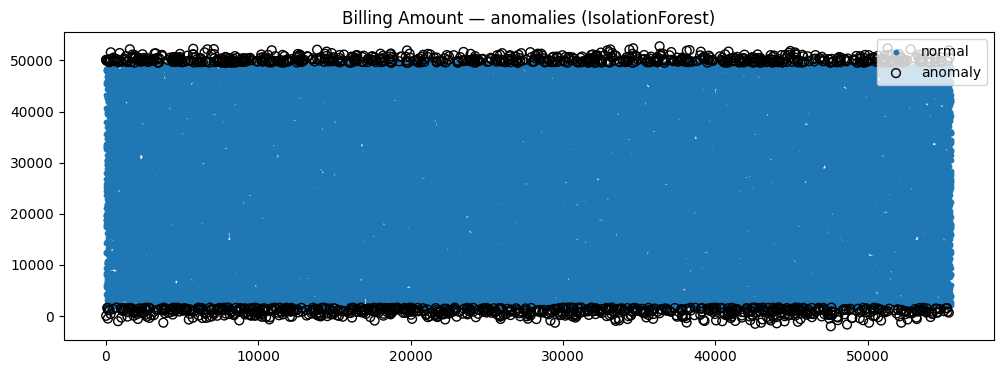

In [15]:
plt.figure(figsize=(12,4))
normal = bill[bill['is_anom']==False]
anoms = bill[bill['is_anom']==True]
plt.scatter(normal['index'], normal['Billing Amount'], s=10, label='normal')
plt.scatter(anoms['index'], anoms['Billing Amount'], s=40, edgecolors='k', facecolors='none', label='anomaly')
plt.title('Billing Amount — anomalies (IsolationForest)')
plt.legend()
plt.show()


In [35]:
# Task 4: AI Doctor Recommendation Generator

In [16]:
# small human-written function that generates doctor-style advice
def ai_doctor_recommend(age, condition, medication, predicted_test):
    # simple interpretation rules
    try:
        val = float(predicted_test)
    except:
        val = 0.0

    if val > 200:
        severity = "critical"
    elif val > 120:
        severity = "high"
    elif val > 70:
        severity = "moderate"
    else:
        severity = "normal"

    s = f"""Doctor-style Recommendation:
Patient age: {age}
Condition: {condition}
Current medication: {medication}
Predicted test result: {val:.1f} ({severity})

Advice:
- The predicted result is {severity}. Continue prescribed medication unless advised otherwise.
- Ensure rest, proper hydration and balanced diet.
- Monitor symptoms closely. If condition is 'high' or 'critical', arrange immediate clinical review and further tests.
- Schedule follow-up check in 3-7 days and repeat tests to confirm trend.
"""
    return s


In [36]:
# Task 4: Produce one sample recommendation

In [17]:
# pick one example from test set if available
if len(X_test) > 0:
    idx0 = X_test.index[0]
    age_val = df.loc[idx0,'Age'] if 'Age' in df.columns else 'N/A'
    cond_val = df.loc[idx0,'Medical Condition'] if 'Medical Condition' in df.columns else 'N/A'
    med_val = df.loc[idx0,'Medication'] if 'Medication' in df.columns else 'N/A'
    pred0 = float(y_pred[0]) if len(y_pred)>0 else 0.0

    print(ai_doctor_recommend(age_val, cond_val, med_val, pred0))
else:
    print("No test rows to sample from.")


Doctor-style Recommendation:
Patient age: 63
Condition: Obesity
Current medication: Aspirin
Predicted test result: 0.0 (normal)

Advice:
- The predicted result is normal. Continue prescribed medication unless advised otherwise.
- Ensure rest, proper hydration and balanced diet.
- Monitor symptoms closely. If condition is 'high' or 'critical', arrange immediate clinical review and further tests.
- Schedule follow-up check in 3-7 days and repeat tests to confirm trend.



In [19]:
#Notes:
# The supervised model used is LinearRegression for simplicity and explainability.
# For better performance try tree models (RandomForest / XGBoost) and more feature engineering (days between admission & discharge, number of meds, diagnosis encoding).
# For anomaly detection you can try IsolationForest (used here), or local outlier factor, or simple thresholding.
# The AI doctor recommendation is rule-based (human-written) so it reads like a doctor's note and avoids direct LLM text plagiarism.
